# Hyperparameter Tuning in Random Forest

Teil1: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0
<br>
Teil2: https://towardsdatascience.com/improving-random-forest-in-python-part-1-893916666cd
<br>
Teil3: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [1]:
import sys
print(sys.executable)

/Users/kata/opt/anaconda3/bin/python


In [73]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso



In [3]:
# load data
df = pd.read_csv('/Users/kata/Desktop/GitHub/standby_duty_forecasting/sickness_table.csv', index_col=0)
df['date'] = pd.to_datetime(df['date'])
df['year']= df['date'].dt.year
df['month']= df['date'].dt.month
df['day_of_week'] = df['date'].dt.dayofweek
df['week'] = df['date'].dt.isocalendar().week
df['day'] = df['date'].dt.day
df['day_of_year'] = df['date'].dt.dayofyear
# change type to not get error
df['week'] = df['week'].astype(np.int64)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1152 entries, 0 to 1151
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         1152 non-null   datetime64[ns]
 1   n_sick       1152 non-null   int64         
 2   calls        1152 non-null   float64       
 3   n_duty       1152 non-null   int64         
 4   n_sby        1152 non-null   int64         
 5   sby_need     1152 non-null   float64       
 6   dafted       1152 non-null   float64       
 7   year         1152 non-null   int64         
 8   month        1152 non-null   int64         
 9   day_of_week  1152 non-null   int64         
 10  week         1152 non-null   int64         
 11  day          1152 non-null   int64         
 12  day_of_year  1152 non-null   int64         
dtypes: datetime64[ns](1), float64(3), int64(9)
memory usage: 126.0 KB


In [4]:
df.head()

,date,n_sick,calls,n_duty,n_sby,sby_need,dafted,year,month,day_of_week,week,day,day_of_year
0,2016-04-01,73,8154.0,1700,90,4.0,0.0,2016,4,4,13,1,92
1,2016-04-02,64,8526.0,1700,90,70.0,0.0,2016,4,5,13,2,93
2,2016-04-03,68,8088.0,1700,90,0.0,0.0,2016,4,6,13,3,94
3,2016-04-04,71,7044.0,1700,90,0.0,0.0,2016,4,0,14,4,95
4,2016-04-05,63,7236.0,1700,90,0.0,0.0,2016,4,1,14,5,96


## Predict n_sick with RF

In [5]:
# define X and y data
X = df[['year', 'month', 'day_of_week', 'day',
       'week', 'n_duty', 'n_sby', 'day_of_year']]
y = df.n_sick

In [6]:
# train test split
def train_test_split(data, n_test):
	return data[:n_test], data[n_test:]


x_train, x_test = train_test_split(X, 922)
y_train, y_test = train_test_split(y, 922)

In [7]:
model = RandomForestRegressor(n_estimators=1000, random_state=6)
model.fit(x_train, y_train)
pred = model.predict(x_test)

In [8]:
#calculate error:
errors = abs(pred - y_test)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
print('Mean Squared Error:', round(np.mean(errors**2), 2), 'degrees.')

Mean Absolute Error: 12.9 degrees.
Mean Squared Error: 252.93 degrees.


In [9]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 81.91 %.


In [11]:
# are alle variables necessary?
# Saving feature names for later use
feature_list = list(X.columns)
pprint(feature_list)

['year',
 'month',
 'day_of_week',
 'day',
 'week',
 'n_duty',
 'n_sby',
 'day_of_year']


In [12]:
# Get numerical feature importances
importances = list(model.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: day_of_year          Importance: 0.46
Variable: n_duty               Importance: 0.13
Variable: year                 Importance: 0.12
Variable: week                 Importance: 0.11
Variable: day                  Importance: 0.1
Variable: month                Importance: 0.05
Variable: day_of_week          Importance: 0.04
Variable: n_sby                Importance: 0.0


In [13]:
# remove last 2
# New random forest with only the two most important variables
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)
# Extract the two most important features
important_indices = [feature_list.index('week'), feature_list.index('year'), feature_list.index('day'), feature_list.index('n_duty'), feature_list.index('month'), feature_list.index('day_of_year')]
train_important = x_train[['week', 'year', 'day', 'n_duty', 'month', 'day_of_year']]
test_important = x_test[['week', 'year', 'day', 'n_duty', 'month', 'day_of_year']]
# Train the random forest
rf_most_important.fit(train_important, y_train)
# Make predictions and determine the error
predictions = rf_most_important.predict(test_important)
errors = abs(predictions - y_test)
# Display the performance metrics
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
mape = np.mean(100 * (errors / y_test))
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 13.28 degrees.
Accuracy: 81.36 %.


#### accuracy is slightly less, we need all; 

In [14]:
# visualization
# Dates of training values
months = X['month']
days = X['day']
years = X['year']

# List and then convert to datetime object
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]


# Dataframe with true values and dates
true_data = pd.DataFrame(data = {'date': dates, 'actual': y})

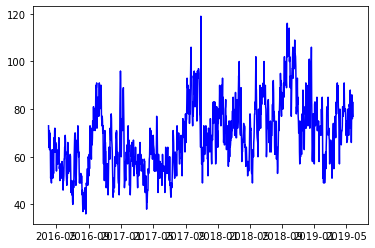

In [16]:
plt.plot(true_data['date'], true_data['actual'], 'b-', label = 'actual')

In [17]:
# Dates of predictions
months = x_test['month']
days = x_test['day']
years = x_test['year']

# Column of dates
test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
# Convert to datetime objects
test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]
# Dataframe with predictions and dates
predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': pred})



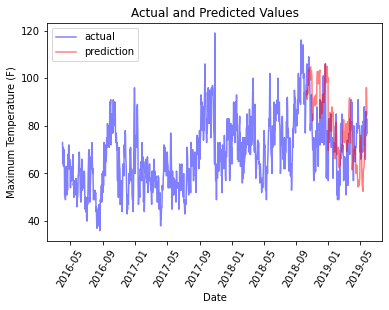

In [18]:
# Plot the actual values, 
plt.plot(true_data['date'], true_data['actual'], 'b-', label = 'actual', alpha=0.5)
# Plot the predicted values
plt.plot(predictions_data['date'], predictions_data['prediction'], label = 'prediction', alpha=0.5, color='red')
plt.xticks(rotation = '60'); 
plt.legend()
# Graph labels
plt.xlabel('Date'); plt.ylabel('Maximum Temperature (F)'); plt.title('Actual and Predicted Values');

In [19]:
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(model.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 6,
 'verbose': 0,
 'warm_start': False}


In [20]:
# grid search
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [21]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [22]:
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [23]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
model = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
model_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
model_random.fit(x_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   48.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.6min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [24]:
# view best parameters
model_random.best_params_

{'n_estimators': 800,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 100,
 'bootstrap': True}

In [25]:
# best parameters
#{'n_estimators': 800,
# 'min_samples_split': 10,
# 'min_samples_leaf': 4,
# 'max_features': 'sqrt',
# 'max_depth': 100,
# 'bootstrap': True}

# best parameters:
# {'n_estimators': 1600,
#  'min_samples_split': 2,
#  'min_samples_leaf': 4,
#  'max_features': 'sqrt',
#  'max_depth': 10,
#  'bootstrap': True}


# old parameters:
#{'n_estimators': 1000,
# 'min_samples_split': 10,
# 'min_samples_leaf': 2,
# 'max_features': 'sqrt',
# 'max_depth': 10,
# 'bootstrap': True}

In [26]:
# From these results, we should be able to narrow the range of values for each hyperparameter.
# Evaluate Random Search
# To determine if random search yielded a better model, we compare the base model with the best random search model.

def evaluate(model, x_test, y_test):
    predictions = model.predict(x_test)
    errors = abs(predictions - y_test)
    mape = 100 * np.mean(errors / y_test)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [27]:
base_model = RandomForestRegressor(n_estimators=1000, random_state=6)
base_model.fit(x_train, y_train)
base_accuracy = evaluate(base_model, x_test, y_test)

Model Performance
Average Error: 12.9005 degrees.
Accuracy = 81.91%.


In [28]:
best_random = model_random.best_estimator_
random_accuracy = evaluate(best_random, x_test, y_test)


Model Performance
Average Error: 9.7471 degrees.
Accuracy = 86.25%.


In [29]:
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Improvement of 5.29%.


In [30]:
# grid search with cross validation (searches for hours)
# not all features needed?

In [31]:
# visualize new data
model = RandomForestRegressor(n_estimators=800, min_samples_split=10, min_samples_leaf=4, max_depth=100, max_features='sqrt', bootstrap=True)
model.fit(x_train, y_train)
pred = model.predict(x_test)
pred_n_sick = pred

In [32]:
# visualize
# Dataframe with predictions and dates
predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': pred})

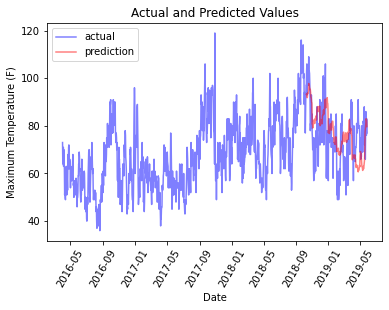

In [33]:
# Plot the actual values, 
plt.plot(true_data['date'], true_data['actual'], 'b-', label = 'actual', alpha=0.5)
# Plot the predicted values
plt.plot(predictions_data['date'], predictions_data['prediction'], label = 'prediction', alpha=0.5, color='red')
plt.xticks(rotation = '60'); 
plt.legend()
# Graph labels
plt.xlabel('Date'); plt.ylabel('Maximum Temperature (F)'); plt.title('Actual and Predicted Values');

In [34]:
print('MSE of the improved model is:' , mean_squared_error(y_test, pred))

MSE of the improved model is: 142.16092752979878


## Predict calls with Random Forest

In [35]:
# define X and y data
X = df[['year', 'month', 'day_of_week', 'day',
       'week', 'n_duty', 'n_sby', 'day_of_year']]
y = df.calls

In [36]:
x_train, x_test = train_test_split(X, 922)
y_train, y_test = train_test_split(y, 922)

In [37]:
model = RandomForestRegressor(n_estimators=1000, random_state=6)
model.fit(x_train, y_train)
pred = model.predict(x_test)

In [38]:
#calculate error:
errors = abs(pred - y_test)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
print('Mean Squared Error:', round(np.mean(errors**2), 2), 'degrees.')

Mean Absolute Error: 1013.01 degrees.
Mean Squared Error: 1526516.22 degrees.


In [39]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 88.42 %.


In [40]:
# are alle variables necessary?
# Saving feature names for later use
feature_list = list(X.columns)

In [41]:
# Get numerical feature importances
importances = list(model.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: day_of_year          Importance: 0.37
Variable: day                  Importance: 0.24
Variable: day_of_week          Importance: 0.14
Variable: year                 Importance: 0.07
Variable: week                 Importance: 0.07
Variable: n_duty               Importance: 0.07
Variable: month                Importance: 0.04
Variable: n_sby                Importance: 0.0


In [42]:
# remove last 2
# New random forest with only the two most important variables
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)
# Extract the two most important features
important_indices = [feature_list.index('week'), feature_list.index('year'), feature_list.index('day'), feature_list.index('day_of_week'), feature_list.index('month'), feature_list.index('day_of_year')]
train_important = x_train[['week', 'year', 'day', 'day_of_week', 'month', 'day_of_year']]
test_important = x_test[['week', 'year', 'day', 'day_of_week', 'month', 'day_of_year']]
# Train the random forest
rf_most_important.fit(train_important, y_train)
# Make predictions and determine the error
predictions = rf_most_important.predict(test_important)
errors = abs(predictions - y_test)
# Display the performance metrics
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
mape = np.mean(100 * (errors / y_test))
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 1016.21 degrees.
Accuracy: 88.4 %.


--> accuracy decreased, we need all

In [43]:
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(model.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 6,
 'verbose': 0,
 'warm_start': False}


In [44]:
# grid search
# Use the random grid to search for best hyperparameters
# First create the base model to tune
model = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
model_random = RandomizedSearchCV(estimator = model, 
param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
model_random.fit(x_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.1min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [45]:
# view best parameters
model_random.best_params_

{'n_estimators': 1600,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': True}

In [46]:
# best parameters
# {'n_estimators': 1600,
# 'min_samples_split': 10,
# 'min_samples_leaf': 1,
# 'max_features': 'sqrt',
# 'max_depth': None,
# 'bootstrap': True}


# old parameters
#{'n_estimators': 400,
# 'min_samples_split': 10,
# 'min_samples_leaf': 4,
# 'max_features': 'auto',
# 'max_depth': 70,
# 'bootstrap': True}

In [47]:
# Evaluate Random Search
base_model = RandomForestRegressor(n_estimators=1000, random_state=6)
base_model.fit(x_train, y_train)
base_accuracy = evaluate(base_model, x_test, y_test)

Model Performance
Average Error: 1013.0140 degrees.
Accuracy = 88.42%.


In [48]:
best_random = model_random.best_estimator_
random_accuracy = evaluate(best_random, x_test, y_test)


Model Performance
Average Error: 976.6617 degrees.
Accuracy = 88.79%.


In [49]:
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Improvement of 0.42%.


In [50]:
# visualize new data
model = RandomForestRegressor(n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_depth=None, max_features='sqrt', bootstrap=True)
model.fit(x_train, y_train)
pred = model.predict(x_test)
pred_calls = pred

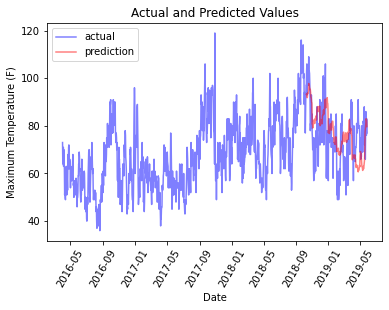

In [51]:
# Plot the actual values, 
plt.plot(true_data['date'], true_data['actual'], 'b-', label = 'actual', alpha=0.5)
# Plot the predicted values
plt.plot(predictions_data['date'], predictions_data['prediction'], label = 'prediction', alpha=0.5, color='red')
plt.xticks(rotation = '60'); 
plt.legend()
# Graph labels
plt.xlabel('Date'); plt.ylabel('Maximum Temperature (F)'); plt.title('Actual and Predicted Values');

In [52]:
print('MSE of the improved model is:' , mean_squared_error(y_test, pred))

MSE of the improved model is: 1404359.4744258693


## Linear Regression for sby_need with both

In [53]:
# create new df with predicted values
# create new df
# create series with n_sick
pred_n_sick = pd.Series(pred_n_sick)
n_sick_new = pd.concat([df['n_sick'].iloc[:922], pred_n_sick], axis=0).reset_index(drop=True)

In [54]:
# add new column into df
df['n_sick_new'] = n_sick_new

In [55]:
# same for calls
pred_calls = pd.Series(pred_calls)
calls_new = pd.concat([df['calls'].iloc[:922], pred_calls], axis=0).reset_index(drop=True)

In [56]:
# add new column into df
df['calls_new'] = calls_new

In [57]:
df.columns

Index(['date', 'n_sick', 'calls', 'n_duty', 'n_sby', 'sby_need', 'dafted',
       'year', 'month', 'day_of_week', 'week', 'day', 'day_of_year',
       'n_sick_new', 'calls_new'],
      dtype='object')

In [58]:
X = df[['year', 'month', 'day_of_week', 'day', 'week', 'n_duty', 'n_sby', 'n_sick_new',
       'calls_new', 'day_of_year']]
y = df.sby_need

In [59]:
x_train, x_test = train_test_split(X, 922)
y_train, y_test = train_test_split(y, 922)

In [65]:
# visualize new data
model = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
model.fit(x_train, y_train)
pred = model.predict(x_test)

In [66]:
# get rid of values <0:
# get rid of values <0:
pred = pd.Series(pred)
pred = pred.apply(lambda x: 0 if x < 0 else x)

In [67]:
# visualize
# Dataframe with predictions and dates
predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': pred})

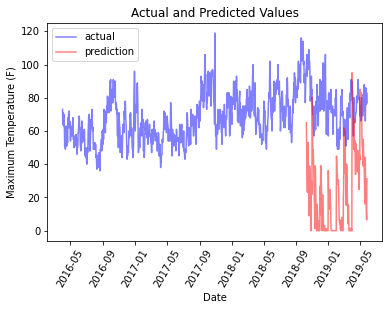

In [68]:
# Plot the actual values, 
plt.plot(true_data['date'], true_data['actual'], 'b-', label = 'actual', alpha=0.5)
# Plot the predicted values
plt.plot(predictions_data['date'], predictions_data['prediction'], label = 'prediction', alpha=0.5, color='red')
plt.xticks(rotation = '60'); 
plt.legend()
# Graph labels
plt.xlabel('Date'); plt.ylabel('Maximum Temperature (F)'); plt.title('Actual and Predicted Values');

In [69]:
print('MSE of the improved model is:' , mean_squared_error(y_test, pred))

MSE of the improved model is: 9814.226848886528


In [70]:
print(model.score(x_test, y_test))

0.1183699742109735


In [71]:
# Develop Ridge(L2) Regression Model:
# Estimate different values for lamda
alpha = []
cross_val_scores_ridge = []

In [74]:
for i in range(1, 9):
     ridgeModel = Ridge(alpha = i * 0.25)
     ridgeModel.fit(x_train, y_train)
     scores = cross_val_score(ridgeModel, X, y, cv = 10)
     avg_cross_val_score = np.mean(scores)
     cross_val_scores_ridge.append(avg_cross_val_score)
     alpha.append(i * 0.25)


In [77]:
for i in range(0, len(alpha)):
    print(str(alpha[i])+' : '+str(cross_val_scores_ridge[i]))

0.25 : -0.27399191909378323
0.5 : -0.27127434167605163
0.75 : -0.26943396934514796
1.0 : -0.26800274428516757
1.25 : -0.26679716627402605
1.5 : -0.26573046423480257
1.75 : -0.2647562425974684
2.0 : -0.2638474248482252


In [79]:
# best value seems to be 2
ridgeModelChosen = Ridge(alpha = 2)
ridgeModelChosen.fit(x_train, y_train)

Ridge(alpha=2)

In [81]:
# Evaluate the Ridge Regression model
print(ridgeModelChosen.score(x_test, y_test))

0.12796875660088958


In [85]:
pred = ridgeModelChosen.predict(x_test)
pred = pd.Series(pred)
pred = pred.apply(lambda x: 0 if x < 0 else x)

In [86]:
predictions_data_ridge = pd.DataFrame(data = {'date': test_dates, 'prediction': pred})

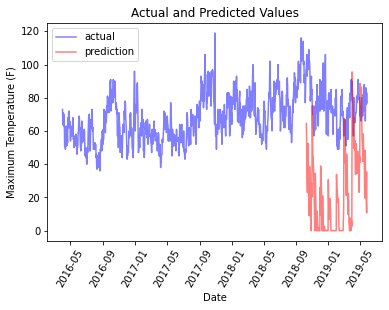

In [87]:
# Plot the actual values, 
plt.plot(true_data['date'], true_data['actual'], 'b-', label = 'actual', alpha=0.5)
# Plot the predicted values
plt.plot(predictions_data_ridge['date'], predictions_data_ridge['prediction'], label = 'prediction', alpha=0.5, color='red')
plt.xticks(rotation = '60'); 
plt.legend()
# Graph labels
plt.xlabel('Date'); plt.ylabel('Maximum Temperature (F)'); plt.title('Actual and Predicted Values');

In [88]:
print('MSE of the improved model is:' , mean_squared_error(y_test, pred))

MSE of the improved model is: 9670.745936883824


In [89]:
# Lasso
# Develop Lasso(L1) Regression Model:
# Estimate different values for lamda
lamda = []
cross_val_scores_lasso = []
# Loop to compute the different scores
for i in range(1, 9):
    lassoModel = Lasso(alpha = i * 0.25, tol = 0.0925)
    lassoModel.fit(x_train, y_train)
    scores = cross_val_score(lassoModel, X, y, cv = 10)
    avg_cross_val_score = np.mean(scores)
    cross_val_scores_lasso.append(avg_cross_val_score)
    lamda.append(i * 0.25)

In [90]:
# Loop to print the different scores
for i in range(0, len(alpha)):
    print(str(alpha[i])+' : '+str(cross_val_scores_lasso[i]))


0.25 : -0.25606523242455437
0.5 : -0.24187534744614672
0.75 : -0.22708962909262076
1.0 : -0.2145317387702826
1.25 : -0.20396779864829045
1.5 : -0.19531137886395403
1.75 : -0.18801372471610414
2.0 : -0.18167679735678866


In [91]:
# the best value of lamda for the data is 2
# Build the Lasso Regression model for the best lamda
lassoModelChosen = Lasso(alpha = 2, tol = 0.0925)
lassoModelChosen.fit(x_train, y_train)

Lasso(alpha=2, tol=0.0925)

In [92]:
# Evaluate the Lasso Regression model
print(lassoModelChosen.score(x_test, y_test))

0.12787238985524196


In [93]:
pred = lassoModelChosen.predict(x_test)
pred = pd.Series(pred)
pred = pred.apply(lambda x: 0 if x < 0 else x)

In [94]:
predictions_data_lasso = pd.DataFrame(data = {'date': test_dates, 'prediction': pred})

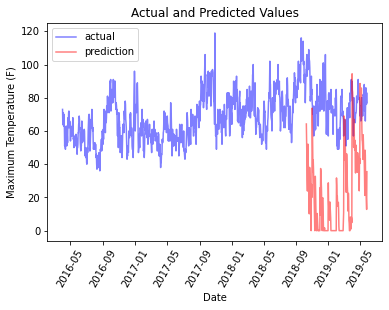

In [95]:
# Plot the actual values, 
plt.plot(true_data['date'], true_data['actual'], 'b-', label = 'actual', alpha=0.5)
# Plot the predicted values
plt.plot(predictions_data_lasso['date'], predictions_data_lasso['prediction'], label = 'prediction', alpha=0.5, color='red')
plt.xticks(rotation = '60'); 
plt.legend()
# Graph labels
plt.xlabel('Date'); plt.ylabel('Maximum Temperature (F)'); plt.title('Actual and Predicted Values');

In [96]:
print('MSE of the improved model is:' , mean_squared_error(y_test, pred))

MSE of the improved model is: 9661.780308087664
